# Gaussian Approximation Potential of EC/EMC Solvent

Ioan-Bogdan Magdău and Gábor Csányi

In this tutorial, you will learn how to fit a machine learned interatomic potential using the Gaussian Approximation Potential (GAP) framework. We will create a simple potential for the the ethylene carbonate / ethyl methyl carbonate (EC/EMC) 33%:67% liquid solvent.

As input data, we will use liquid configurations which were sampled with a classical force field. The data we will fit to: energies, forces and virials were computed with DFT (PBE+G06).

The tutorial assumes that you are familiar with python and notebooks. We use the GAP code which is freely available as part of [QUIP](https://github.com/libAtoms/QUIP) to create and use the potential and the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) package to manage atoms, molecules and trajectories.

This copy is "read only", so you need to click on the project title on the top left and "duplicate" the project here on Deepnote, and then you can execute and modify the notebook. Make sure your "Environment" is set to "GAP-tutorial-docker" which ensures you have access to QUIP and ASE.

If the notebook stops responding (e.g. figures don't appear, the subprocesses such as GAP fitting don't seem to work), just restart the virtual machine in the "Environment" tab from the left menu)

# The precomputed PBE+G06 database

In [ ]:
import numpy as np
from ase.io import read, write
from ase.visualize import view

db = read('ECEMC.xyz', ':') # read in database

print("Number of frames in database: ", len(db))
print("Number of atoms in each frame: ", np.array([len(at) for at in db]))
print("Information stored in typical frame: ", db[3].info.keys(), db[3].arrays.keys())

Number of frames in database:  203
Number of atoms in each frame:  [  1   1   1 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160
 160 160 160 160 160]
Information stored in typical frame:  dict_keys(['temperature', 'density', 'energy', 'virial']) dict_keys(['

GAP fits to atomization energies (eV), so we need to provide the energy of each atom species in vacuum for reference. First three frames are isolated atoms.

In [ ]:
E0 = {at.get_chemical_symbols()[0] : at.info['energy'] for at in db[:3]}
print(E0)

{'H': -12.353708076955, 'C': -148.1794822322, 'O': -431.46315818255}


Next 200 frames are EC/EMC liquid configurations. Each configuration contains 4 EC molecules (first 40 atoms) and 8 EMC molecules (last 120 atoms)

In [ ]:
view(db[100], viewer='x3d')

In [ ]:
mol = db[100][0:10] # select 100th frame, first 10 atoms
mol.center(about=[0,0,0])
view(mol, viewer='x3d') # an EC molecule

In [ ]:
mol = db[100][40:55] # select 100th frame, atoms 41st to 55th
mol.center(about=[0,0,0])
view(mol, viewer='x3d') # an EMC molecule

The liquid database spans multiple densities and temperatures. For reference the density we expect at 300 K for EC/EMC (33:67) is around 1.08 $g/cm^3$

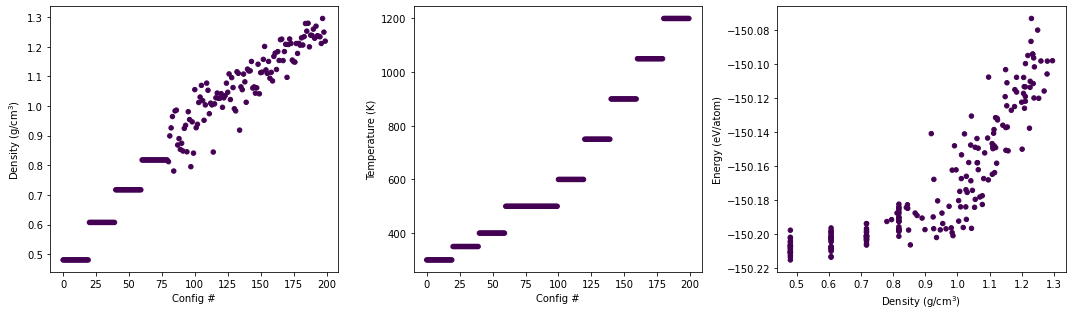

In [ ]:
import matplotlib.pyplot as plt

def plot_thermo(data, col=np.array([])):
    if not col.size:
        col = np.zeros(len(data))
    idx = np.arange(len(data))
    temp = np.array([at.info['temperature'] for at in data])
    dens = np.array([at.info['density'] for at in data])
    eng = np.array([at.info['energy']/len(at) for at in data])
    plt.figure(figsize=(15, 4.5))
    plt.subplot(1,3,1)
    plt.scatter(idx, dens, s=20, c=col)
    plt.xlabel('Config #')
    plt.ylabel(r'Density (g/cm$^3)$')
    plt.subplot(1,3,2)
    plt.scatter(idx, temp, s=20, c=col)
    plt.xlabel('Config #')
    plt.ylabel(r'Temperature (K)')
    plt.subplot(1,3,3)
    plt.scatter(dens, eng, s=20, c=col)
    plt.xlabel(r'Density (g/cm$^3)$')
    plt.ylabel('Energy (eV/atom)')
    plt.tight_layout()

plot_thermo(db[3:])

Each `atoms` object stores total energy, forces and total virial. We will copy these in a dictionary for easier access later.

In [ ]:
eng = []
frc = []
vir = []

for at in db[3:]:
    eng += [at.info['energy']]
    frc += [at.arrays['forces']]
    vir += [at.info['virial']]

ref_data = {}
ref_data['energy'] = np.array(eng) # energy unit is eV
ref_data['forces'] = np.array(frc) # forces unit is eV/Ang
ref_data['virial'] = np.array(vir) # virial unit is eV/Ang^3

# Fitting a simple Many-Body GAP model

We will create our training set around the expected equilibrium density at 500 K.

/venv/lib/python3.9/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '
Choise of training set: 40  frames out of  200 frames


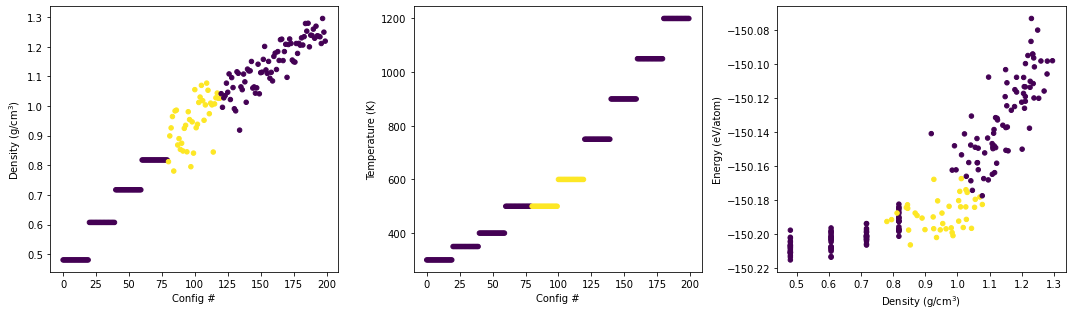

In [ ]:
train = db[83:123] # select every 10th config
col = np.zeros(len(db[3:]))
col[80:120] = 1
write('ECEMC_train.xyz', db[:3]+train) # write train set to disk

print('Choise of training set:', len(train), ' frames out of ', len(db[3:]), 'frames')
plot_thermo(db[3:], col)

Now we are going to fit our first GAP model to PBE+G06 energies, forces and virials. We will start by fitting a many-body model using the Smooth Overlap of Atomic Positions (SOAP) descriptor. There are many paramters, most of which are briefly explained bellow.


In [ ]:
gp_name = "GAP.xml"  # this will be the file name of our new potential
train_name = "ECEMC_train.xyz"

# SOAP descriptor
# n_sparse: number of basis functions in the sparse Gaussian process. fitting scales as the square of this, evaluation linearly
# n_max, l_max: radial and angular truncation of the neighbour density expansion
# cutoff: cutoff distance of the neighbour density
# atom_sigma: width of Gaussian smearing applied to each atom when making the local neighbour density
# delta: magnitude of atomic energy function we are fitting
# covariance_type: functional form of the covariance kernel. with SOAP, we typically use the dot product kernel
# zeta: power the dot_product kernel is raised to, resulting in a polynomial kernel
# sparse_method: how to select basis locations for the sparse Gaussian process, cur_points is a good way in high dimensions

desc_str_soap = f"soap n_sparse=100 n_max=6 l_max=4 cutoff=3.0 cutoff_transition_width=1.0 atom_sigma=0.5 "\
                f"add_species=True delta=0.1 covariance_type=dot_product zeta=4 sparse_method=cur_points"

# kernel regularisation parameters, correspondsing to: energy(per atom) [eV], force [eV/A], virial (per atom) [eV], hessian (not used here)
default_sigma = "0.001 0.020 0.1 1.0"

# NEW descriptor str
fit_str = f"gap_fit at_file={train_name} gp_file={gp_name} " \
            f"energy_parameter_name=energy force_parameter_name=forces virial_parameter_name=virial " \
            f"sparse_jitter=1.0e-8 do_copy_at_file=F sparse_separate_file=F " \
            f"default_sigma={{ {default_sigma} }} e0_method=isolated " \
            f"gap={{ {desc_str_soap} }}"
            
# fit the GAP model
import subprocess
proc = subprocess.run(fit_str, shell=True, capture_output=True, text=True)
print(proc.stdout)

libAtoms::Hello World: 24/01/2022   12:54:34
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP,7ef0bd1-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Jun 19 2021 at 07:34:45
libAtoms::Hello World: OpenMP parallelisation with 2 threads
libAtoms::Hello World: Random Seed = 46474995
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

atoms_filename = //MANDATORY//
at_file = ECEMC_train.xyz
gap = " soap n_sparse=100 n_max=6 l_max=4 cutoff=3.0 cutoff_transition_width=1.0 atom_sigma=0.5 add_species=True delta=0.1 covariance_type=dot_product zeta=4 sparse_method=cur_points"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = isolated
default_kernel_regularisation = //MANDATORY//
default_sigma = " 0.001 0.020 0.1 1.0"
default_kernel_regularisation_local_property = 0.001
default_local_p

Investigate the output of the `gap_fit` command: it reports details about data, descriptors, fitting and it is a great way to ensure we are doing the right thing.

# Testing the MB GAP model

Let's test our GAP model by predicting energies, forces and virials on the entire database (most of which - 80% - new configurations).

In [ ]:
from quippy.potential import Potential # This is class that allows a GAP model to be called as an ASE calculator
gap_pot = Potential("", param_filename=gp_name)

def predict_values(frames, calculator):
    eng = []
    frc = []
    vir = []
    for frame in frames:
        frame.calc = calculator
        eng += [frame.get_potential_energy()]
        frc += [frame.get_forces()]
        vir += [-frame.get_stress(voigt=False)*frame.get_volume()]
        del frame.calc
    return {'energy': np.array(eng), 'forces': np.array(frc), 'virial': np.array(vir)}

data = predict_values(db[3:], gap_pot)

As an aside, beware of the horrible trap of the ASE calculator. Try commenting out the line `del frame.calc` above, rerun the prediction and then run this test. You will see all the frames in the collection have the same energy. This is because `frame.calc` is actually a reference to a `calculator` object and not a field of the `atoms` object. Since all `atoms` are now pointing to the same `calculator`, at write time, the energy value will be the same, and identical to the last value stored in the `calculator` memory. Moving on ...

In [ ]:
write('test.xyz', db[3:])
test = read('test.xyz', ':')
for i, at in enumerate(test):
    print('Energy at frame ', i, ' is: ', at.get_potential_energy())

Energy at frame  0  is:  -24033.16553133
Energy at frame  1  is:  -24034.01061056
Energy at frame  2  is:  -24033.08067308
Energy at frame  3  is:  -24032.76529595
Energy at frame  4  is:  -24033.77188561
Energy at frame  5  is:  -24031.63840647
Energy at frame  6  is:  -24033.60590341
Energy at frame  7  is:  -24033.32094834
Energy at frame  8  is:  -24033.76234748
Energy at frame  9  is:  -24032.66657813
Energy at frame  10  is:  -24033.4775468
Energy at frame  11  is:  -24032.30419999
Energy at frame  12  is:  -24034.16892006
Energy at frame  13  is:  -24034.43584352
Energy at frame  14  is:  -24032.38959761
Energy at frame  15  is:  -24033.28298602
Energy at frame  16  is:  -24033.68669654
Energy at frame  17  is:  -24033.75336758
Energy at frame  18  is:  -24033.11573287
Energy at frame  19  is:  -24032.99960986
Energy at frame  20  is:  -24033.61358393
Energy at frame  21  is:  -24034.18184564
Energy at frame  22  is:  -24034.11770645
Energy at frame  23  is:  -24033.29504516
Ene

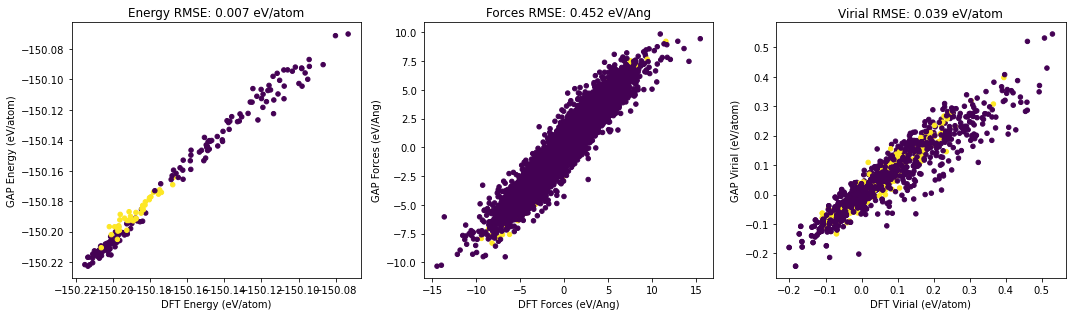

In [ ]:
def calc_RMSE(a, b):
    return np.sqrt(np.mean(np.square(a-b)))

# this function creates scatter plots for energy, forces and virial
# the reference is fixed to ref_data
def plot_scatter(data):
    Natoms = len(db[3])
    plt.figure(figsize=(15, 4.5))
    plt.subplot(1,3,1)
    plt.scatter(ref_data['energy']/Natoms, data['energy']/Natoms, s=20, c=col)
    plt.xlabel('DFT Energy (eV/atom)')
    plt.ylabel('GAP Energy (eV/atom)')
    plt.title('Energy RMSE: {0:.3f} eV/atom'.format(calc_RMSE(ref_data['energy']/Natoms, data['energy']/Natoms)))
    plt.subplot(1,3,2)
    plt.scatter(ref_data['forces'], data['forces'], s=20, c=np.repeat(col, 160*3))
    plt.xlabel('DFT Forces (eV/Ang)')
    plt.ylabel('GAP Forces (eV/Ang)')
    plt.title('Forces RMSE: {0:.3f} eV/Ang'.format(calc_RMSE(ref_data['forces'], data['forces'])))
    plt.subplot(1,3,3)
    plt.scatter(ref_data['virial']/Natoms, data['virial']/Natoms, s=20, c=np.repeat(col, 9))
    plt.xlabel('DFT Virial (eV/atom)')
    plt.ylabel('GAP Virial (eV/atom)')
    plt.title('Virial RMSE: {0:.3f} eV/atom'.format(calc_RMSE(ref_data['virial']/Natoms, data['virial']/Natoms)))
    plt.tight_layout()

plot_scatter(data)

This errorrs are reasonable for such a coarse GAP model. In real application, we aim to achieve force accuracies of about 0.1 eV/Ang for a radial cut-off of 6 Ang. Those models can take up to 1.5TB of memory to fit, here we are restricted to 5GB memory.

# A few things one could try

- Change the model parameters to see how this how this influences the accuracy of the fit and also the required computing resources. Interesting things to look at: radial cutoff, amount of training data, number of basis functions, number of sparse points, regularization. A larger cut-off is desirable to achieve a better potential, however you may find it requires significantly more data and more complex models to fit owing to the rapid increase of atomic environment diversity.

- Choose a different training set to include configs at different densities and temperatures. This would be ideal in a real application, here you may find that a more diverse training set is harder to fit within the computational constraints.

# Running MD simulations with GAP

Now we will run some MD with our potential. This is the ultimate test: we might find a potential which performs well on the homogeneous training set, but may stray into exotic regions of space space when running dynamics. In real applications, these `holes` on the potential energy surface (pes) are extremly valuable for the iterative training process.

We will start from a liquid configuration thermalized with OPLS. This configuration might be far from the true thermal equilibrium of PBE so it helps to first minimize it, before running dynamics. As an exercise you can try to run the dynamics without minimization and check the difference. If the potential is robust this should not matter, however for our toy potential it can make a difference.

In [ ]:
from ase.optimize.bfgs import BFGS

frame = db[100].copy() # make a static copy of an OPLS config
frame.center()
frame.calc = gap_pot # attach the GAP calculator

opt = BFGS(frame, trajectory="OPTGAP.traj") # perform a coarse geometry optimization
opt.run(fmax=0.3)

      Step     Time          Energy         fmax
BFGS:    0 13:01:27   -24030.827869        6.4021
BFGS:    1 13:01:27   -24037.240471        6.6730
BFGS:    2 13:01:27   -24039.245468        2.6229
BFGS:    3 13:01:28   -24040.676912        1.2966
BFGS:    4 13:01:28   -24041.916469        1.5343
BFGS:    5 13:01:28   -24042.546172        1.6019
BFGS:    6 13:01:28   -24042.988365        0.7870
BFGS:    7 13:01:28   -24043.263482        0.8292
BFGS:    8 13:01:28   -24043.505987        0.5374
BFGS:    9 13:01:29   -24043.719473        0.5752
BFGS:   10 13:01:29   -24043.893649        0.5971
BFGS:   11 13:01:29   -24044.050455        0.4745
BFGS:   12 13:01:29   -24044.193242        0.4632
BFGS:   13 13:01:29   -24044.325410        0.5050
BFGS:   14 13:01:29   -24044.453059        0.6249
BFGS:   15 13:01:30   -24044.585796        0.6163
BFGS:   16 13:01:30   -24044.717947        0.5151
BFGS:   17 13:01:30   -24044.849590        0.5155
BFGS:   18 13:01:30   -24044.983549        0.5019
B

True

Let's view the configuration at the end of the optimization with GAP. The default viewer here only shows static snapshots. You could view the trajectory offline using [OVITO](https://www.ovito.org/) which can read the `.xyz` trajectory files. Download `OPTGAP.xyz` on your computer and view it try to open it. 

In [ ]:
view(frame, viewer='x3d')
opt_name = "OPTGAP.xyz"  # this will be the file name of our optimization trajectory
opt_gap_traj = read('OPTGAP.traj', ":") # read the binary .traj file
write(opt_name, opt_gap_traj) # ... and rewrite it in .xyz format to open with OVITO
opt_gap_traj[-1].center(about=[0,0,0])
view(opt_gap_traj[-1], viewer='x3d')

The optimized configuration looks ok, the molecules are still in one piece. Try repeating the optimization with a more stringent `fmax` condition. You might find molecules stating to distort which is a sign that our potential is finding holes on the pes. We could substantially improve this potential with more computational resources at hand.

# NVT dynamics

We can now run 1 ps of NVT dynamics, where we keep the volume fixed and sample modest temperatures (300 K). Try increasing the temperatures to check how robust the potential is. Refit with different parameters and check again the dynamics. This is part of the iterative training process.

In [ ]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.langevin import Langevin
from ase import units
from time import time

Temp = 300 # K
dt = 1 # fs
Nsamp = 10 # sampling rate
Tsim = 1e+3 # fs
densfct = (units.m/1.0e2)**3/units.mol # convert from au/A^3 to g/cm^3

frame = opt_gap_traj[-1].copy() # if you rerun the block, ensure you start from the same frame each time
frame.center()
frame.calc = gap_pot

# initial velocities
MaxwellBoltzmannDistribution(frame, temperature_K=Temp) # Set the momenta corresponding to temperature
Stationary(frame)  # zero out total linear momentum
ZeroRotation(frame)# zero out total angular momentum

# create the dynamics object in this case NVT ensemble
dyn = Langevin(frame, dt*units.fs, temperature_K=Temp, 
               friction=0.1, trajectory="MDGAP.traj")

md_epot = []
md_ekin = []
md_temp = []
md_dens = []

def printenergy(a=frame):  # store a reference to atoms in the definition.
    """Function to print the thermodynamics properties."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    dens = np.sum(a.get_masses()) / a.get_volume() * densfct
    md_epot.append(epot)
    md_ekin.append(ekin)
    md_temp.append(ekin/(1.5*units.kB))
    md_dens.append(dens)

    if len(md_ekin) % Nsamp == 0:
        print('Epot = %.3f eV/atom  Ekin = %.3f eV/atom '
              'Temp = %3.0f K Dens: %.3f g/cm^3' % (epot, ekin, ekin / (1.5 * units.kB), dens), flush=True)

dyn.attach(printenergy, interval=1)

t0 = time()
dyn.run(int(Tsim))
t1 = time()
print("MD finished in {0:.2f} minutes".format((t1-t0)/60)) # with default parameters this should take around 1.8 minutes 

Epot = -150.605 eV/atom  Ekin = 0.022 eV/atom Temp = 174 K Dens: 0.795 g/cm^3
Epot = -150.603 eV/atom  Ekin = 0.023 eV/atom Temp = 181 K Dens: 0.795 g/cm^3
Epot = -150.605 eV/atom  Ekin = 0.026 eV/atom Temp = 203 K Dens: 0.795 g/cm^3
Epot = -150.607 eV/atom  Ekin = 0.027 eV/atom Temp = 210 K Dens: 0.795 g/cm^3
Epot = -150.609 eV/atom  Ekin = 0.032 eV/atom Temp = 250 K Dens: 0.795 g/cm^3
Epot = -150.617 eV/atom  Ekin = 0.040 eV/atom Temp = 310 K Dens: 0.795 g/cm^3
Epot = -150.622 eV/atom  Ekin = 0.044 eV/atom Temp = 339 K Dens: 0.795 g/cm^3
Epot = -150.624 eV/atom  Ekin = 0.044 eV/atom Temp = 339 K Dens: 0.795 g/cm^3
Epot = -150.624 eV/atom  Ekin = 0.044 eV/atom Temp = 340 K Dens: 0.795 g/cm^3
Epot = -150.629 eV/atom  Ekin = 0.050 eV/atom Temp = 389 K Dens: 0.795 g/cm^3
Epot = -150.630 eV/atom  Ekin = 0.051 eV/atom Temp = 395 K Dens: 0.795 g/cm^3
Epot = -150.628 eV/atom  Ekin = 0.047 eV/atom Temp = 366 K Dens: 0.795 g/cm^3
Epot = -150.635 eV/atom  Ekin = 0.052 eV/atom Temp = 406 K Dens:

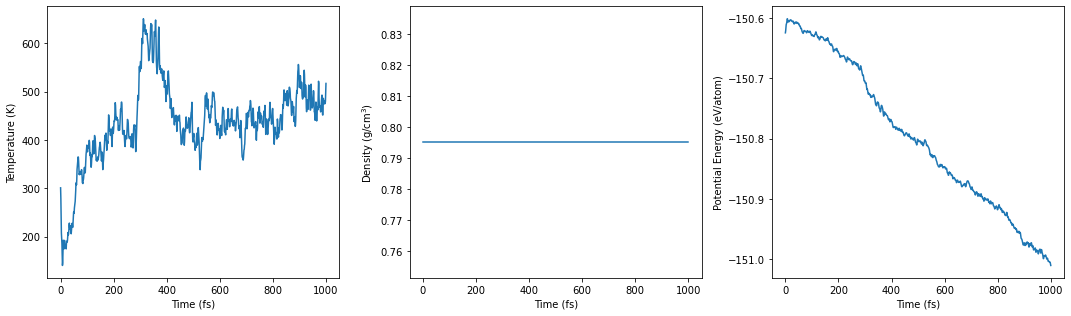

In [ ]:
def plot_md(md_temp, md_dens, md_epot):
    plt.figure(figsize=(15, 4.5))
    plt.subplot(1,3,1)
    plt.plot(md_temp)
    plt.xlabel('Time (fs)')
    plt.ylabel('Temperature (K)')
    plt.subplot(1,3,2)
    plt.plot(md_dens)
    plt.xlabel('Time (fs)')
    plt.ylabel(r'Density (g/cm$^3$)')
    plt.subplot(1,3,3)
    plt.plot(md_epot)
    plt.xlabel('Time (fs)')
    plt.ylabel(r'Potential Energy (eV/atom)')
    plt.tight_layout()

plot_md(md_temp, md_dens, md_epot)

The trajectory is fairly stable at around 300 K after the initial equilibration. Since we start with an optimized structure, at first, half of the kinetic energy is quickly absorbed into potential energy so the temperature drops to ~150 K. After 300 fs, the potential starts to find hole on the pes which lowers the total potential energy of the system.

In [ ]:
md_name = "MDGAP_NVT.xyz"  # this will be the file name of our trajectory
md_gap_traj = read('MDGAP.traj', ":")
write(md_name, md_gap_traj[::Nsamp])
md_gap_traj = read('MDGAP.traj', ":")
md_gap_traj[-1].center(about=[0,0,0])
view(md_gap_traj[-1], viewer='x3d')

The molecules are still intact. Try running longer trajectories, they will eventually fall apart, indicating the potential needs further refinement to better predict the covalent interactions. To view the trajectory, download `MDGAP_NVT.xyz` locally on your computer and view with OVITO.

# NPT dynamics

We will attempt to run NPT dynamics, where the volume is allowed to fluctuate. In general, this is a stringent test on intermolecular interactions. In this case we do not capture much of the intermolecular interactions because our potential only extends to 3 Ang.

In [ ]:
from ase.md.npt import NPT

Temp = 300 # K
dt = 1 # fs
Nsamp = 10 # sampling rate
Tsim = 1e+3 # fs
densfct = (units.m/1.0e2)**3/units.mol # convert from au/A^3 to g/cm^3

frame = opt_gap_traj[-1].copy() # if you rerun the block, ensure you start from the same frame each time
frame.center()
frame.calc = gap_pot

MaxwellBoltzmannDistribution(frame, temperature_K=Temp)
Stationary(frame)
ZeroRotation(frame)

# create the dynamics object in this case NPT ensemble
dyn = NPT(frame, dt*units.fs, temperature_K=Temp, externalstress=1*units.bar, mask=np.eye(3),
               ttime=25*units.fs, pfactor=75*units.fs, trajectory="MDGAP.traj")
dyn.set_fraction_traceless(0) # ensured the volume changes isotropically, i.e. x,y and z are coupled


md_epot = []
md_ekin = []
md_temp = []
md_dens = []

def printenergy(a=frame):  # store a reference to atoms in the definition.
    """Function to print the thermodynamics properties."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    dens = np.sum(a.get_masses()) / a.get_volume() * densfct
    md_epot.append(epot)
    md_ekin.append(ekin)
    md_temp.append(ekin/(1.5*units.kB))
    md_dens.append(dens)

    if len(md_ekin) % Nsamp == 0:
        print('Epot = %.3f eV/atom  Ekin = %.3f eV/atom '
              'Temp = %3.0f K Dens: %.3f g/cm^3' % (epot, ekin, ekin / (1.5 * units.kB), dens), flush=True)

dyn.attach(printenergy, interval=1)

t0 = time()
dyn.run(int(Tsim))
t1 = time()
print("MD finished in {0:.2f} minutes".format((t1-t0)/60)) # with default parameters this should take around 3.9 minutes 

Epot = -150.609 eV/atom  Ekin = 0.022 eV/atom Temp = 173 K Dens: 0.795 g/cm^3
Epot = -150.605 eV/atom  Ekin = 0.023 eV/atom Temp = 175 K Dens: 0.795 g/cm^3
Epot = -150.605 eV/atom  Ekin = 0.032 eV/atom Temp = 246 K Dens: 0.796 g/cm^3
Epot = -150.598 eV/atom  Ekin = 0.038 eV/atom Temp = 294 K Dens: 0.796 g/cm^3
Epot = -150.591 eV/atom  Ekin = 0.048 eV/atom Temp = 375 K Dens: 0.797 g/cm^3
Epot = -150.588 eV/atom  Ekin = 0.062 eV/atom Temp = 480 K Dens: 0.797 g/cm^3
Epot = -150.581 eV/atom  Ekin = 0.062 eV/atom Temp = 483 K Dens: 0.797 g/cm^3
Epot = -150.584 eV/atom  Ekin = 0.060 eV/atom Temp = 465 K Dens: 0.796 g/cm^3
Epot = -150.591 eV/atom  Ekin = 0.053 eV/atom Temp = 407 K Dens: 0.794 g/cm^3
Epot = -150.594 eV/atom  Ekin = 0.040 eV/atom Temp = 306 K Dens: 0.793 g/cm^3
Epot = -150.601 eV/atom  Ekin = 0.032 eV/atom Temp = 251 K Dens: 0.793 g/cm^3
Epot = -150.607 eV/atom  Ekin = 0.028 eV/atom Temp = 219 K Dens: 0.794 g/cm^3
Epot = -150.612 eV/atom  Ekin = 0.027 eV/atom Temp = 206 K Dens:

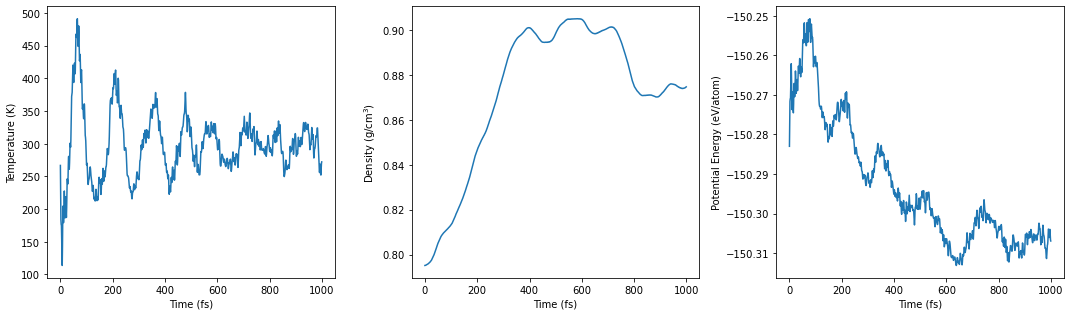

In [ ]:
plot_md(md_temp, md_dens, md_epot)

Compared to NVT, here density can fluctuate. The large temperature fluctuations are due to the thermostat, try adjusting the friction term `ttime` and monitor the effect on the fluctuations. For 1 ps the trajectory is failry stable, try increasing the temperature and the simulation time, the toy potential will eventually fail. In real application, it is easier the fit the intramolecular part of the interactions so we find that NVT simulations quickly become stable after a few iterations. NPT stability takes a lot more work since the liquid is kept together by intermolecular interactions which are more difficult to capture.

In [ ]:
md_name = "MDGAP_NPT.xyz"  # this will be the file name of our trajectory
md_gap_traj = read('MDGAP.traj', ":")
write(md_name, md_gap_traj[::Nsamp])
md_gap_traj = read('MDGAP.traj', ":")
md_gap_traj[-1].center(about=[0,0,0])
view(md_gap_traj[-1], viewer='x3d')

To view the trajectory, download `MDGAP_NPT.xyz` locally on your computer and view with OVITO.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=133e51b0-8d70-40b3-bccf-2cbe5b483427' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>